 # Thuật toán Decision Tree - CART

# 1. Import thư viện

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import pandas as pd




*Giải thích*

* numpy: Được sử dụng để xử lý các phép toán ma trận và tính toán hiệu quả.

*   matplotlib.pyplot: Dùng để vẽ biểu đồ, giúp trực quan hóa dữ liệu và kết quả.
* pandas: đọc dữ liệu từ file CSV.

*  KFold: chia dữ liệu thành các tập con (folds) phục vụ cho quá trình cross-validation.




# 2.Định nghĩa lớp DecisionTree

In [13]:
class DecisionTree:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth
        self.tree = None

    def fit(self, X, y):
        self.tree = self._build_tree(X, y, depth=0)

    def predict(self, X):
        return np.array([self._predict_one(x, self.tree) for x in X])

    def _build_tree(self, X, y, depth):
        if depth == self.max_depth or len(np.unique(y)) == 1:
            return np.mean(y)

        best_feature, best_threshold = self._best_split(X, y)
        if best_feature is None:
            return np.mean(y)

        left_indices = X[:, best_feature] <= best_threshold
        right_indices = X[:, best_feature] > best_threshold

        left_tree = self._build_tree(X[left_indices], y[left_indices], depth + 1)
        right_tree = self._build_tree(X[right_indices], y[right_indices], depth + 1)

        return (best_feature, best_threshold, left_tree, right_tree)

    def _predict_one(self, x, tree):
        if not isinstance(tree, tuple):
            return tree
        feature, threshold, left_tree, right_tree = tree
        if x[feature] <= threshold:
            return self._predict_one(x, left_tree)
        else:
            return self._predict_one(x, right_tree)

    def _best_split(self, X, y):
        best_feature = None
        best_threshold = None
        best_mse = float('inf')

        for feature in range(X.shape[1]):
            thresholds = np.unique(X[:, feature])
            for threshold in thresholds:
                left_indices = X[:, feature] <= threshold
                right_indices = X[:, feature] > threshold

                if len(y[left_indices]) == 0 or len(y[right_indices]) == 0:
                    continue

                mse = self._calculate_mse(y[left_indices], y[right_indices])

                if mse < best_mse:
                    best_mse = mse
                    best_feature = feature
                    best_threshold = threshold

        return best_feature, best_threshold

    def _calculate_mse(self, left_y, right_y):
        left_mse = np.mean((left_y - np.mean(left_y)) ** 2) if len(left_y) > 0 else 0
        right_mse = np.mean((right_y - np.mean(right_y)) ** 2) if len(right_y) > 0 else 0
        return (len(left_y) * left_mse + len(right_y) * right_mse) / (len(left_y) + len(right_y))


*Giải thích*

*   Hàm fit(X, y): Dùng để huấn luyện mô hình dựa trên dữ liệu đầu vào X (biến độc lập) và y (biến phụ thuộc). Nó gọi phương thức _build_tree để xây dựng cây quyết định.

*   Hàm _build_tree: Xây dựng cây quyết định đệ quy, kiểm tra từng nhánh để xác định cách phân chia tốt nhất dựa trên đặc trưng của dữ liệu.

*  Hàm _best_split: Tìm kiếm cách phân chia tốt nhất dữ liệu dựa trên giá trị ngưỡng (threshold) sao cho lỗi bình phương trung bình (MSE) là nhỏ nhất.
*  Hàm predict(X): Dùng để dự đoán kết quả cho một tập dữ liệu mới.







# 3. Hàm để tải dữ liệu từ các fold (cross-validation)


In [18]:
def load_fold_data(fold_number):
    train_data = pd.read_csv(f'D:/NgoChucNgoc64KTPM2/HocMayG3/Student-Final-Grade-ML/data/split/K-folds/fold_{fold_number}_train.csv')
    val_data = pd.read_csv(f'D:/NgoChucNgoc64KTPM2/HocMayG3/Student-Final-Grade-ML/data/split/K-folds/fold_{fold_number}_val.csv')

    X_train = train_data[['cw1', 'mid-term', 'cw2']].values
    y_train = train_data['final'].values
    X_val = val_data[['cw1', 'mid-term', 'cw2']].values
    y_val = val_data['final'].values

    return X_train, y_train, X_val, y_val

def load_data_from(path):
    input = pd.read_csv(f'{path}')
    data = input[['cw1', 'mid-term', 'cw2']].values
    label = input[['final']].values
    return data, label


*Giải thích*

*  load_fold_data: Hàm này đọc dữ liệu từ các file CSV chứa các fold cho quá trình cross-validation. Tập dữ liệu bao gồm các biến đầu vào (cw1, mid-term, cw2) và biến mục tiêu (final).
*  load_data_from: Hàm này đọc dữ liệu từ một file CSV được cung cấp và trả về dữ liệu đầu vào và đầu ra dưới dạng mảng numpy.



# 4. Hàm để vẽ biểu đồ lỗi theo độ sâu

In [19]:
def plot_errors(depths, errors):
    plt.plot(depths, errors)
    plt.xlabel('Giá trị độ sâu')
    plt.ylabel('Lỗi trung bình ')
    plt.title('Lỗi theo các giá trị độ sâu')
    plt.show()


*Giải thích*

*   Giải thích: Hàm này tải dữ liệu từ file CSV theo từng fold trong quá trình cross-validation. Nó chia dữ liệu thành tập huấn luyện (train) và tập kiểm tra (val) để huấn luyện và đánh giá mô hình..





# 5.Thiết lập độ sâu cần kiểm tra cho cây quyết định

In [20]:
depth_values = range(1, 11)


*Giải thích*

*  Giới hạn độ sâu: Bạn sẽ thử nghiệm các giá trị độ sâu từ 1 đến 10 để tìm ra giá trị phù hợp nhất cho cây quyết định. Độ sâu của cây quyết định quyết định số lượng lần phân chia dữ liệu, cây càng sâu thì mô hình càng phức tạp.





# 6.Huấn luyện mô hình với cross-validation và tìm độ sâu tối ưu

In [21]:
errors = []
best_depth = None
lowest_error = float('inf')

for depth in depth_values:
    fold_errors = []
    for fold in range(5):
        X_train, y_train, X_val, y_val = load_fold_data(fold)

        # Khởi tạo mô hình cây quyết định với độ sâu hiện tại
        tree = DecisionTree(max_depth=depth)
        tree.fit(X_train, y_train)

        # Dự đoán trên tập validation
        y_pred = tree.predict(X_val)

        # Tính lỗi MSE
        mse = np.mean((y_val - y_pred) ** 2)
        fold_errors.append(mse)

    # Trung bình lỗi MSE trên tất cả các fold
    avg_error = np.mean(fold_errors)
    errors.append(avg_error)

    # Tìm độ sâu với lỗi thấp nhất
    if avg_error < lowest_error:
        lowest_error = avg_error
        best_depth = depth

    print(f"Depth = {depth}, Average Fold Error = {avg_error}")


Depth = 1, Average Fold Error = 0.7286371099806551
Depth = 2, Average Fold Error = 0.4076676705849337
Depth = 3, Average Fold Error = 0.34964791031771536
Depth = 4, Average Fold Error = 0.33702353155102416
Depth = 5, Average Fold Error = 0.34626480625902295
Depth = 6, Average Fold Error = 0.34901282144566015
Depth = 7, Average Fold Error = 0.3298670451402059
Depth = 8, Average Fold Error = 0.35643678275307866
Depth = 9, Average Fold Error = 0.37627776932956636
Depth = 10, Average Fold Error = 0.390665612106903


*Giải thích*


*  Tạo danh sách lỗi errors và các biến lưu trữ: errors là danh sách để lưu lại lỗi MSE tương ứng với từng giá trị độ sâu. best_depth lưu giá trị độ sâu có lỗi nhỏ nhất, và lowest_error khởi tạo với giá trị lớn nhất để dễ so sánh.

*   Vòng lặp qua các giá trị độ sâu: Tại mỗi bước, mô hình cây quyết định được khởi tạo với độ sâu khác nhau từ 1 đến 10.

*   Cross-validation: Mỗi giá trị độ sâu sẽ được đánh giá thông qua K-fold cross-validation (k = 5). Dữ liệu được chia thành 5 phần, và tại mỗi vòng lặp, mô hình huấn luyện trên 4 phần và kiểm tra trên phần còn lại.
*   Huấn luyện và tính toán lỗi:Với mỗi fold, bạn huấn luyện cây quyết định trên tập huấn luyện (X_train, y_train), sau đó dự đoán trên tập kiểm tra (X_val). Mean Squared Error (MSE): Đây là thước đo được dùng để tính độ lệch giữa giá trị dự đoán (y_pred) và giá trị thật (y_val).


*   Tìm giá trị độ sâu tốt nhất: Tại mỗi độ sâu, bạn tính toán lỗi trung bình trên tất cả các fold và lưu lại giá trị lỗi trung bình đó trong errors.
Nếu lỗi trung bình của độ sâu hiện tại nhỏ hơn lỗi nhỏ nhất trước đó, cập nhật giá trị của best_depth và lowest_error.






# 7.In ra độ sâu tối ưu

In [22]:
print(f'Độ sâu tối ưu (thủ công): {best_depth}')


Độ sâu tối ưu (thủ công): 7


*Giải thích *


*  Sau khi kiểm tra qua tất cả các độ sâu, bạn in ra độ sâu có lỗi thấp nhất (độ sâu tốt nhất) dựa trên quá trình huấn luyện.




# 8.Dự đoán trên tập kiểm tra (test set)

In [23]:
X_test, y_test = load_data_from('D:/NgoChucNgoc64KTPM2/HocMayG3/Student-Final-Grade-ML/data/split/test_data.csv')
tree = DecisionTree(max_depth=best_depth)
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)


*Giải thích*


*   Dữ liệu kiểm tra: Tập kiểm tra được nạp từ file test_data.csv thông qua hàm load_data_from trong cart_utils.py. Dữ liệu này sẽ được sử dụng để đánh giá mô hình trên tập dữ liệu chưa từng được nhìn thấy trong quá trình huấn luyện.
*   Huấn luyện với độ sâu tối ưu: Sau khi đã xác định độ sâu tốt nhất, bạn huấn luyện lại cây quyết định trên toàn bộ tập huấn luyện (X_train, y_train) và dự đoán trên tập kiểm tra (X_test).



# 9.Tính lỗi trên tập kiểm tra và vẽ biểu đồ lỗi

Lỗi trung bình trên tập test (thủ công): 3.6164119641352857


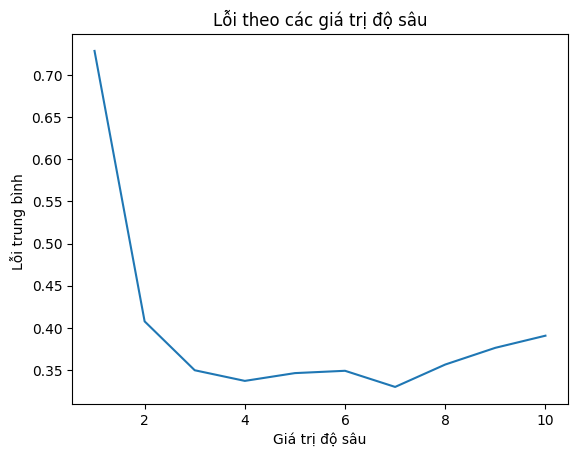

In [24]:
mse_test = np.mean((y_test - y_pred) ** 2)
print(f'Lỗi trung bình trên tập test (thủ công): {mse_test}')
plot_errors(depth_values, errors)


*Giải thích*

*   Tính lỗi MSE trên tập kiểm tra: Mô hình dự đoán trên tập kiểm tra (X_test), sau đó bạn tính toán lỗi MSE giữa giá trị dự đoán và giá trị thực của tập kiểm tra.
*   Vẽ biểu đồ lỗi: Hàm plot.plot_errors được gọi để vẽ biểu đồ thể hiện lỗi MSE thay đổi theo từng độ sâu của cây quyết định. Điều này giúp bạn trực quan hóa quá trình tối ưu hóa độ sâu.



